<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#カラーマップをgradsに合わせる" data-toc-modified-id="カラーマップをgradsに合わせる-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>カラーマップをgradsに合わせる</a></span></li></ul></div>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import glob
import sys
sys.path.append("/home/oonishi_t/Pylib/")
import custom_colorbar

In [3]:
#複数の変数が入ったgradsバイナリを読み込む
def read_mulit_gs(file,xmax,ymax,zmax,t,nvar,zdims=None,varnames=None,na_value=-327.68):
    #z次元が統一されていない
    if zdims is not None:
        if varnames is None:
            gsdtype=np.dtype([(f"var{i}",f"<{xmax*ymax*z}f") for i,z in zip(range(nvar),zdims)])
        else:
            gsdtype=np.dtype([(f"{varname}",f"<{xmax*ymax*z}f") for varname,z in zip(varnames,zdims)])
    #zがすべて同じ
    else:
        if varnames is None:
            gsdtype=np.dtype([(f"var{i}",f"<{xmax*ymax*zmax}f") for z in zdims])
        else:
            gsdtype=np.dtype([(f"{varname}",f"<{xmax*ymax*zmax}f") for varname in varnames])        
    with open(file,"br") as f:
        chunk=np.fromfile(f,dtype=gsdtype,count=t)
    return chunk[0]

In [4]:
def read_gs(file,x,y,z,t,na_value=-327.68):
    gsdtype=np.dtype([("arr",f"<{x*y*z}f")])
    with open(file,"br") as f:
        chunk=np.fromfile(f,dtype=gsdtype,count=t)
    arr= chunk[0]["arr"].reshape((z,y,x),order="C")
    arr=np.where(arr==na_value,np.nan,arr)
    arr=np.where(arr==255,np.nan,arr)
    return arr

## カラーマップをgradsに合わせる

In [5]:
from matplotlib.colors import LinearSegmentedColormap,BoundaryNorm
#gradsっぽいカラーマップ
gscolors=np.array([
    [160,0 ,200,1],#purple
    [130,0 ,220,1],#dark purple
    [30 ,60,255,1],#dark blue
    [0, 160,255,1],#medium blue
    [0, 200,200,1],#light blue
    [0, 210,140,1],#aqua
    [0,220,0,1],   #green
    [160,230,50,1],#yellow/green
    [230,220,50,1],#yellow
    [230,175,45,1],#dark yellow
    [240,130,40,1],#orange
    [250,60,60,1],#red
    [240,0,130,1]#magenta
],dtype=np.float)
gscolors[:,:3]/=256 #RGBを0-1の範囲に変換
gscmap=LinearSegmentedColormap.from_list("gscmap2",colors=gscolors)

In [7]:
files=glob.glob("./JMAradar/CHUBU/2020/09/202009*.dat")
productfiles=glob.glob("./JMAradar_product/CHUBU/radar_202009*.bin")
files.sort()
productfiles.sort()
print(len(files),len(productfiles))

60 60


vil     1  99 ZE 鉛直積算水分量

ch      1  99 ZE　雲長強度

mr      1  99 ZE　最大雨量強度

ct      1  99 ZE　雲長強度

mt      1  99 ZE　最強層強度

cap     15 99 ZE　降水強度


In [8]:
gscolors=custom_colorbar.get_gscolors()
gscolors[0:2,:]=[0.8,0.8,0.8,1]
gscolors=gscolors[1:,:]
gscolors.shape
gscmap2=custom_colorbar.make_cmap(gscolors)

In [9]:
len([0,0.1,0.5,1.0,3.0,5.0,10.0,15.0,20.0,30.0,50.0,80])

12

In [10]:
def plot_axes(ax,xx,yy,data,zlev,levels,cmap,norm,extend="max"):
    ax.coastlines()
    gl=ax.gridlines(draw_labels=True,linestyle="--")
    gl.top_labels=False
    gl.right_labels=False
    cf=ax.contourf(xx,yy,data[zlev,:,:],transform=ccrs.PlateCarree()
                   ,cmap=cmap,norm=norm
                   ,levels=levels,alpha=0.9,extend=extend)
    return cf

In [11]:
lon=np.linspace(134.4353,134.4353+500*0.0110,500)
lat=np.linspace(33.0027777,33.0027777+500*0.009,500)
xx,yy=np.meshgrid(lon,lat)
plt.rcParams["font.size"]=16
levels=[0,1.0,3.0,5.0,10.0,15.0,20.0,30.0,50.0,80]
norm=BoundaryNorm(levels,ncolors=gscmap.N)

202009070300 radar_202009070300 ./JMAradar/CHUBU/2020/09/202009070300.dat ./JMAradar_product/CHUBU/radar_202009070300.bin


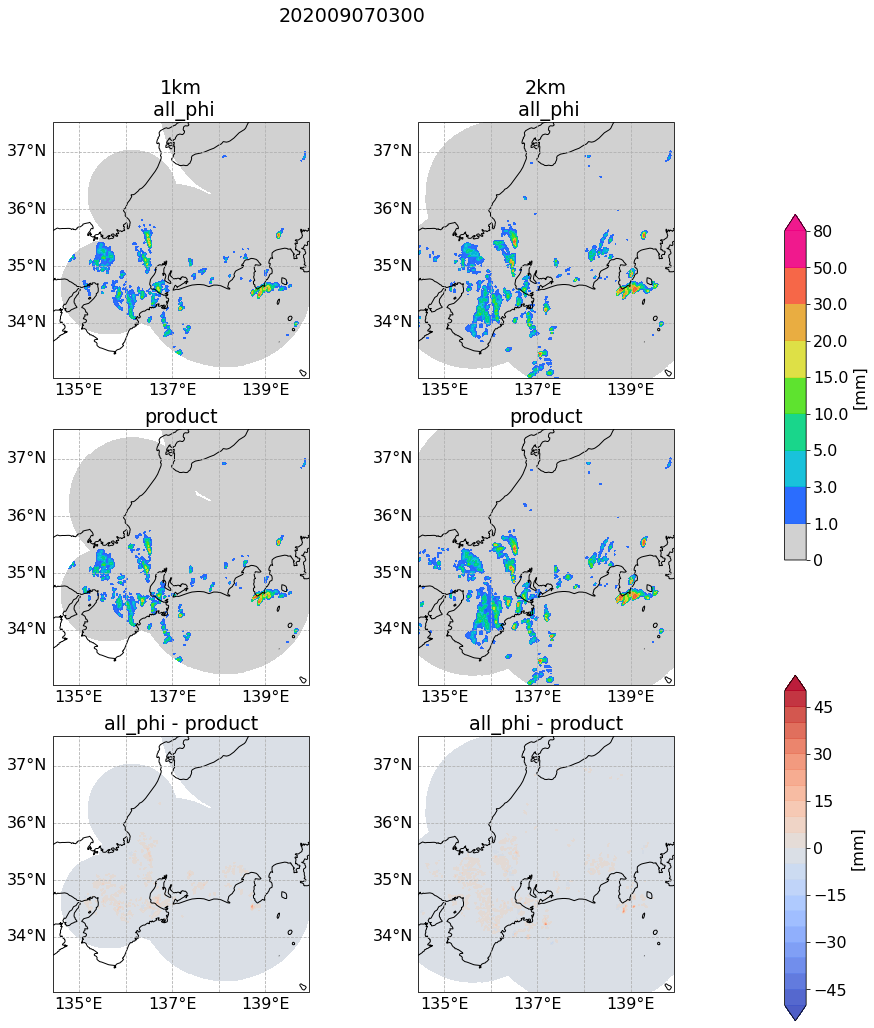

In [15]:
lon=np.linspace(134.4353,134.4353+500*0.0110,500)
lat=np.linspace(33.0027777,33.0027777+500*0.009,500)
xx,yy=np.meshgrid(lon,lat)
plt.rcParams["font.size"]=16
levels=[0,1.0,3.0,5.0,10.0,15.0,20.0,30.0,50.0,80]
divlevels=np.arange(-50,50.1,5)

norm=BoundaryNorm(levels,ncolors=gscmap.N)
zlev=0 # zero origin
for file,pfile in zip(files,productfiles):
    newarr=read_gs(file,x=500,y=500,z=15,t=1).round()
    parr=read_mulit_gs(pfile,xmax=500,ymax=500,zmax=15,nvar=6,t=1
                       ,zdims=[1,1,1,1,1,15],varnames=["vil","ch","mr","ct","mt","cap"])["cap"].reshape((15,500,500))
    parr=np.where(parr==255,np.nan,parr).round()
    diff = newarr-parr
    
    datetime=file.split("/")[-1].split(".")[0]
    datetime2=pfile.split('/')[-1].split(".")[0]
    fig=plt.figure(figsize=(12,16),facecolor="w")
    ax=np.zeros((3,2),dtype=np.object)
    iax=0
    for irow in range(3):
        for icol in range(2):
            ax[irow,icol]=fig.add_subplot(3,2,iax+1,projection=ccrs.Mercator())
            iax+=1
    #1km
    cf=plot_axes(ax[0,0],xx,yy,newarr,zlev=0,levels=levels,cmap=gscmap2,norm=norm)
    cf_1=plot_axes(ax[1,0],xx,yy,parr,zlev=0,levels=levels,cmap=gscmap2,norm=norm)
    cf_diff=plot_axes(ax[2,0],xx,yy,diff,zlev=0,levels=divlevels,cmap="coolwarm",norm=None,extend="both")
    
    #2km
    cf2=plot_axes(ax[0,1],xx,yy,newarr,zlev=1,levels=levels,cmap=gscmap2,norm=norm)
    cf_2=plot_axes(ax[1,1],xx,yy,parr,zlev=1,levels=levels,cmap=gscmap2,norm=norm)
    cf_diff=plot_axes(ax[2,1],xx,yy,diff,zlev=1,levels=divlevels,cmap="coolwarm",norm=None,extend="both")
    
    ax[0,0].set_title("1km\n all_phi")
    ax[0,1].set_title("2km\n all_phi")
    ax[1,0].set_title("product")
    ax[1,1].set_title("product")
    ax[2,0].set_title("all_phi - product")
    ax[2,1].set_title("all_phi - product")
    fig.suptitle(f"{datetime}")
    cax=fig.add_axes([1,0.5,0.025,0.3])
    cax2=fig.add_axes([1,0.1,0.025,0.3])
    
    cbar=fig.colorbar(cf,cax)
    cbar.set_label("[mm]")
    cbar.set_ticks(levels)
    cbar.set_ticklabels(levels)
    
    cbardiff=fig.colorbar(cf_diff,cax2)
    cbardiff.set_label("[mm]")
    #cbardiff.set_ticks(divlevels)
    #cbardiff.set_ticklabels(divlevels) 
    
    print(datetime,datetime2,file,pfile)
    break
    fig.savefig(f"./JMAradar/pyfig/CHUBU/vs_product//{datetime}_1-2km.png",bbox_inches="tight")
    plt.close()

In [33]:
np.nanmax(parr)

75.0

(array([3.000e+00, 3.000e+00, 4.000e+00, 3.000e+00, 2.000e+00, 5.000e+00,
        3.000e+00, 7.000e+00, 4.000e+00, 1.100e+01, 1.000e+01, 3.600e+01,
        1.180e+02, 4.300e+02, 2.862e+03, 1.709e+03, 4.810e+02, 1.180e+02,
        6.300e+01, 2.000e+01, 8.000e+00, 4.000e+00, 0.000e+00, 3.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00]),
 array([-30, -28, -26, -24, -22, -20, -18, -16, -14, -12, -10,  -8,  -6,
         -4,  -2,   0,   2,   4,   6,   8,  10,  12,  14,  16,  18,  20,
         22,  24,  26,  28]),
 <a list of 29 Patch objects>)

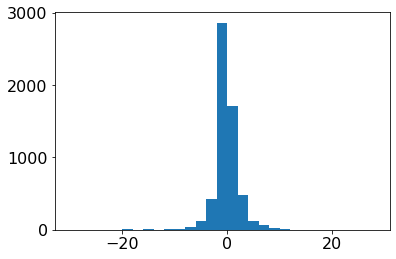

In [37]:
x=diff[0,:,:].flatten()
x=x[~np.isnan(x)]
x=x[x !=0.0]
plt.hist(x,bins=np.arange(-30,30,2))

In [36]:
x.max()

24.0

In [29]:
files=glob.glob("./JMAradar/KANTO/2020/09/20200909124*.dat")
productfiles=glob.glob("./JMAradar_product/KANTO/radar_20200909124*.bin")
files.sort()
productfiles.sort()

202009091240 radar_202009091240 ./JMAradar/KANTO/2020/09/202009091240.dat ./JMAradar_product/KANTO/radar_202009091240.bin


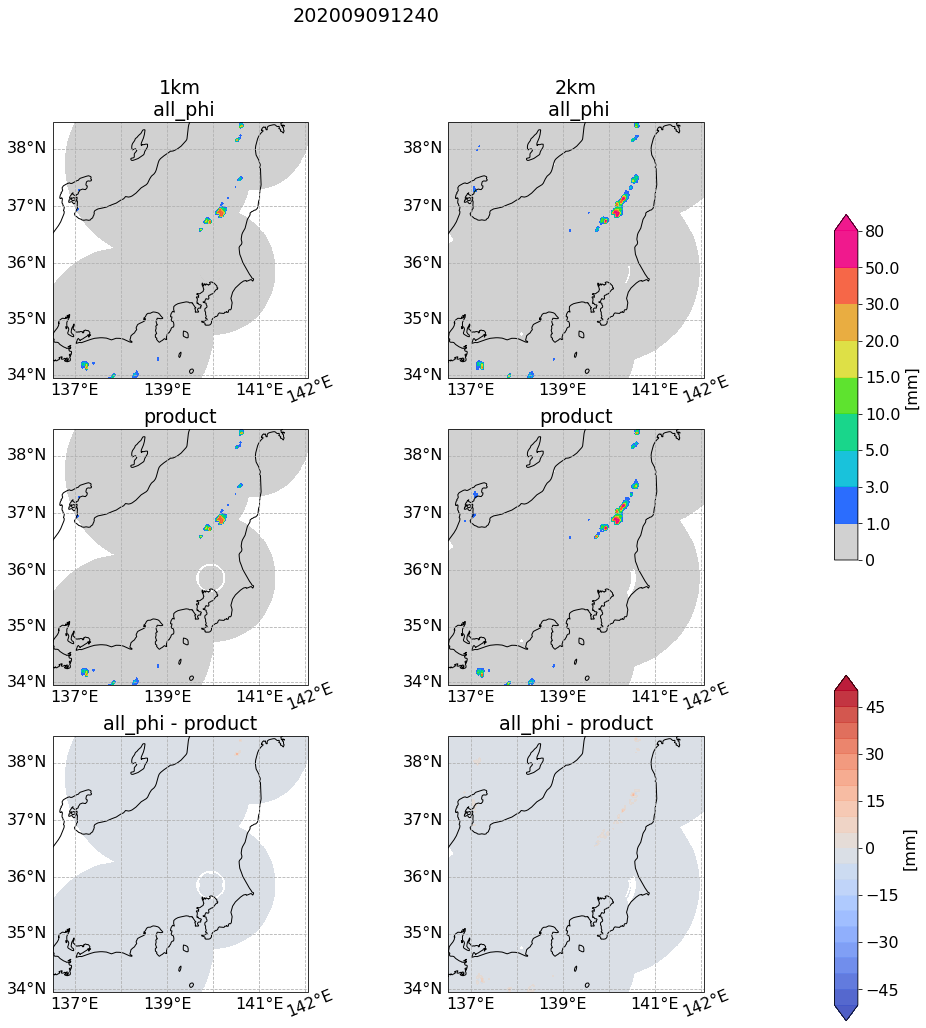

In [30]:
lon=np.linspace(136.5134,136.5134+500*0.0111,500)
lat=np.linspace(33.9513,33.9513+500*0.0090,500)
xx,yy=np.meshgrid(lon,lat)
plt.rcParams["font.size"]=16
levels=[0,1.0,3.0,5.0,10.0,15.0,20.0,30.0,50.0,80]
divlevels=np.arange(-50,50.1,5)

norm=BoundaryNorm(levels,ncolors=gscmap.N)
zlev=0 # zero origin
for file,pfile in zip(files,productfiles):
    newarr=read_gs(file,x=500,y=500,z=15,t=1).round()
    parr=read_mulit_gs(pfile,xmax=500,ymax=500,zmax=15,nvar=6,t=1
                       ,zdims=[1,1,1,1,1,15],varnames=["vil","ch","mr","ct","mt","cap"])["cap"].reshape((15,500,500))
    parr=np.where(parr==255,np.nan,parr).round()
    
    diff = newarr-parr
    
    datetime=file.split("/")[-1].split(".")[0]
    datetime2=pfile.split('/')[-1].split(".")[0]
    fig=plt.figure(figsize=(13,16),facecolor="w")
    ax=np.zeros((3,2),dtype=np.object)
    iax=0
    for irow in range(3):
        for icol in range(2):
            ax[irow,icol]=fig.add_subplot(3,2,iax+1,projection=ccrs.Mercator())
            iax+=1
    #1km
    cf=plot_axes(ax[0,0],xx,yy,newarr,zlev=0,levels=levels,cmap=gscmap2,norm=norm)
    cf=plot_axes(ax[1,0],xx,yy,parr,zlev=0,levels=levels,cmap=gscmap2,norm=norm)
    cf_diff=plot_axes(ax[2,0],xx,yy,diff,zlev=0,levels=divlevels,cmap="coolwarm",norm=None,extend="both")
    
    #2km
    cf=plot_axes(ax[0,1],xx,yy,newarr,zlev=1,levels=levels,cmap=gscmap2,norm=norm)
    cf=plot_axes(ax[1,1],xx,yy,parr,zlev=1,levels=levels,cmap=gscmap2,norm=norm)
    cf_diff=plot_axes(ax[2,1],xx,yy,diff,zlev=1,levels=divlevels,cmap="coolwarm",norm=None,extend="both")
    
    ax[0,0].set_title("1km\n all_phi")
    ax[0,1].set_title("2km\n all_phi")
    ax[1,0].set_title("product")
    ax[1,1].set_title("product")
    ax[2,0].set_title("all_phi - product")
    ax[2,1].set_title("all_phi - product")
    fig.suptitle(f"{datetime}")
    cax=fig.add_axes([1,0.5,0.025,0.3])
    cax2=fig.add_axes([1,0.1,0.025,0.3])
    
    cbar=fig.colorbar(cf,cax)
    cbar.set_label("[mm]")
    cbar.set_ticks(levels)
    cbar.set_ticklabels(levels)
    
    cbardiff=fig.colorbar(cf_diff,cax2)
    cbardiff.set_label("[mm]")
#     cbardiff.set_ticks(divlevels)
#     cbardiff.set_ticklabels(divlevels) 
    print(datetime,datetime2,file,pfile)
#     fig.savefig(f"./JMAradar/pyfig/KANTO/vs_product/{datetime}_1-2km.png",bbox_inches="tight")
#     plt.close()


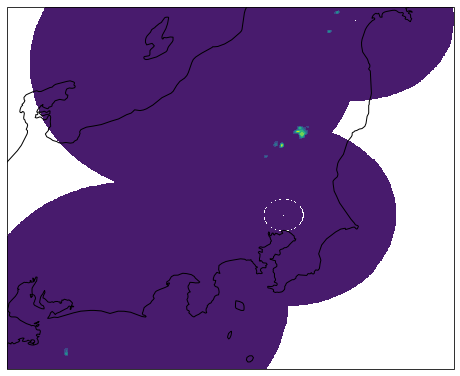

In [32]:
fig=plt.figure(figsize=(8,8))
ax=fig.add_subplot(1,1,1,projection=ccrs.PlateCarree())
ax.coastlines()
ax.contourf(xx,yy,newarr[0,:,:],transform=ccrs.PlateCarree())